# Rescue Mission: Predicting Passenger Disappearances

In [1]:
import warnings
import optuna
import shap
import joblib
import h2o
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.functions import *
from h2o.automl import H2OAutoML
from h2o.exceptions import H2ODependencyWarning
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer,
    LabelEncoder,
)
from sklearn.metrics import (
    make_scorer,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
)
from sklearn.model_selection import (
    cross_validate,
    StratifiedKFold,
    cross_val_score,
    cross_val_predict,
    train_test_split,
)

params = {
    "figure.figsize": (6, 4),
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "xtick.major.size": 0,
    "ytick.major.size": 0,
    "grid.alpha": 0.3,
    "axes.grid": True,
    "axes.grid.axis": "y",
    "axes.edgecolor": "white",
}
plt.rcParams.update(params)
sns.set_palette("deep")

# Dataset Cleaning

The main objectives for this part of the notebook are:

- Get familiar with the dataset.
- Discover data quality issues.
- Address the data quality issues.

## Table Contents

Dataset consists of train and test CSV files.

In [2]:
test_passengers = pd.read_csv("test.csv")
passengers = pd.read_csv("train.csv")
rows, columns = passengers.shape
display(passengers.head())
display(passengers.dtypes)
print(f"{rows} rows and {columns} columns.")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

8693 rows and 14 columns.


Observations:

- The data has 13 predictor variables and 1 target variable indicating whether or not a person was transported to another dimension.
- Three of these features are not directly usable and require feature engineering to extract value: "PassengerId", "Cabin", and "Name".
- Of the remaining features, 4 are categorical and 6 are continuous numerical. The target is binary categorical.
- Target feature is encoded as a boolian datatype.

Impact:
- Some libraries or models might expect categorical or numerical variables. I will change this feature into an object type.

In [3]:
passengers["Transported"] = passengers["Transported"].astype("object")

## Duplicates

In [4]:
print(f'Duplicates by ID number: {passengers.duplicated(subset="PassengerId").any()}')
print(f'Duplicates by name: {passengers.duplicated(subset="Name").any()}')

Duplicates by ID number: False
Duplicates by name: True


Observations:
- There are duplicated names.

Impact:
- Explore these instances.

In [5]:
non_null_names = passengers.dropna(subset=["Name"])
duplicates = non_null_names[non_null_names.duplicated(subset="Name", keep=False)]
duplicates.sort_values(by="Name", ascending=False).head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
3381,3640_02,Earth,True,G/589/S,TRAPPIST-1e,41.0,False,0.0,0.0,0.0,0.0,0.0,Troya Schwardson,False
1737,1850_01,Earth,False,F/356/S,PSO J318.5-22,54.0,False,0.0,316.0,257.0,0.0,0.0,Troya Schwardson,False
2883,3118_01,Earth,True,G/510/P,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,0.0,Sus Coolez,False
4217,4493_01,Earth,False,F/845/S,TRAPPIST-1e,26.0,False,42.0,65.0,895.0,407.0,0.0,Sus Coolez,True
1812,1935_01,Earth,True,G/307/S,55 Cancri e,18.0,False,0.0,0.0,0.0,0.0,0.0,Sharie Gallenry,False


Observations:
- Some people have the same names, but they belong to different groups and have different feature values, so this information is not an error.


## Missing Values

*Most of the actions listed in this sub-section were taken while exploring ways to improve the model.*

In [6]:
number_of_missing_values(passengers)

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
Percentage of rows with missing entries: 24.01%
Number of rows with more than one missing value: 220


Observations:
- Ship logs have been corrupted, and some of the values are missing.
- By inspecting the data, we can find various patterns that allow us to fill in some missing information.

Impact:

- If a passenger is in CryoSleep, their spending values are 0.
- A group is traveling from the same planet.
- Children (below 13 years old) do no spend any money.
- People in the same group are likely to travel in the same cabin, though it's not guaranteed.

In [7]:
warnings.filterwarnings("ignore", category=FutureWarning)
spending_columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
passengers.loc[passengers["CryoSleep"] == True, spending_columns] = passengers.loc[
    passengers["CryoSleep"] == True, spending_columns
].fillna(0)
passengers["PassengerGroup"] = passengers["PassengerId"].str[:4]
passengers["HomePlanet"] = (
    passengers.groupby("PassengerGroup")["HomePlanet"]
    .apply(lambda x: x.ffill().bfill().infer_objects())
    .reset_index(drop=True)
)
passengers["Cabin"] = (
    passengers.groupby("PassengerGroup")["Cabin"]
    .apply(lambda x: x.ffill().bfill().infer_objects())
    .reset_index(drop=True)
)
passengers.drop("PassengerGroup", axis=1, inplace=True)
passengers.loc[passengers["Age"] <= 13, spending_columns] = passengers.loc[
    passengers["Age"] <= 13, spending_columns
].fillna(0)
number_of_missing_values(passengers)

PassengerId       0
HomePlanet      111
CryoSleep       217
Cabin            99
Destination     182
Age             179
VIP             203
RoomService     106
FoodCourt       106
ShoppingMall    103
Spa             109
VRDeck          106
Name            200
Transported       0
dtype: int64
Percentage of rows with missing entries: 18.21%
Number of rows with more than one missing value: 130


Observations:
- Around 5% of missing values have been filled in.

Impact:
- We can fill in more missing information by identifying the subset of passengers with similar features and using the most common value from that subset.
- I worked exclusively with categorical data, but to improve the accuracy of missing value imputation and fill in more gaps, I should also apply this approach to numeric variables. To do this, numeric variables could be categorized.

In [8]:
categorical_features = ["HomePlanet", "CryoSleep", "Destination", "VIP"]
for feature in categorical_features:
    missing_mask = passengers[feature].isnull()
    temp_features = categorical_features.copy()
    temp_features.remove(feature)
    for idx in passengers[missing_mask].index:
        row = passengers.loc[idx]
        subset = passengers[
            (passengers[temp_features[0]] == row[temp_features[0]])
            & (passengers[temp_features[1]] == row[temp_features[1]])
            & (passengers[temp_features[2]] == row[temp_features[2]])
            & (passengers[feature].notnull())
        ]
        if not subset.empty:
            passengers.at[idx, feature] = subset[feature].mode().iloc[0]
number_of_missing_values(passengers)

PassengerId       0
HomePlanet        7
CryoSleep        13
Cabin            99
Destination      10
Age             179
VIP              13
RoomService     106
FoodCourt       106
ShoppingMall    103
Spa             109
VRDeck          106
Name            200
Transported       0
dtype: int64
Percentage of rows with missing entries: 11.35%
Number of rows with more than one missing value: 60


Observations:

- Additional 7% of missing values have been filled in.

## Entry Errors and Anomalies of Numeric Variables

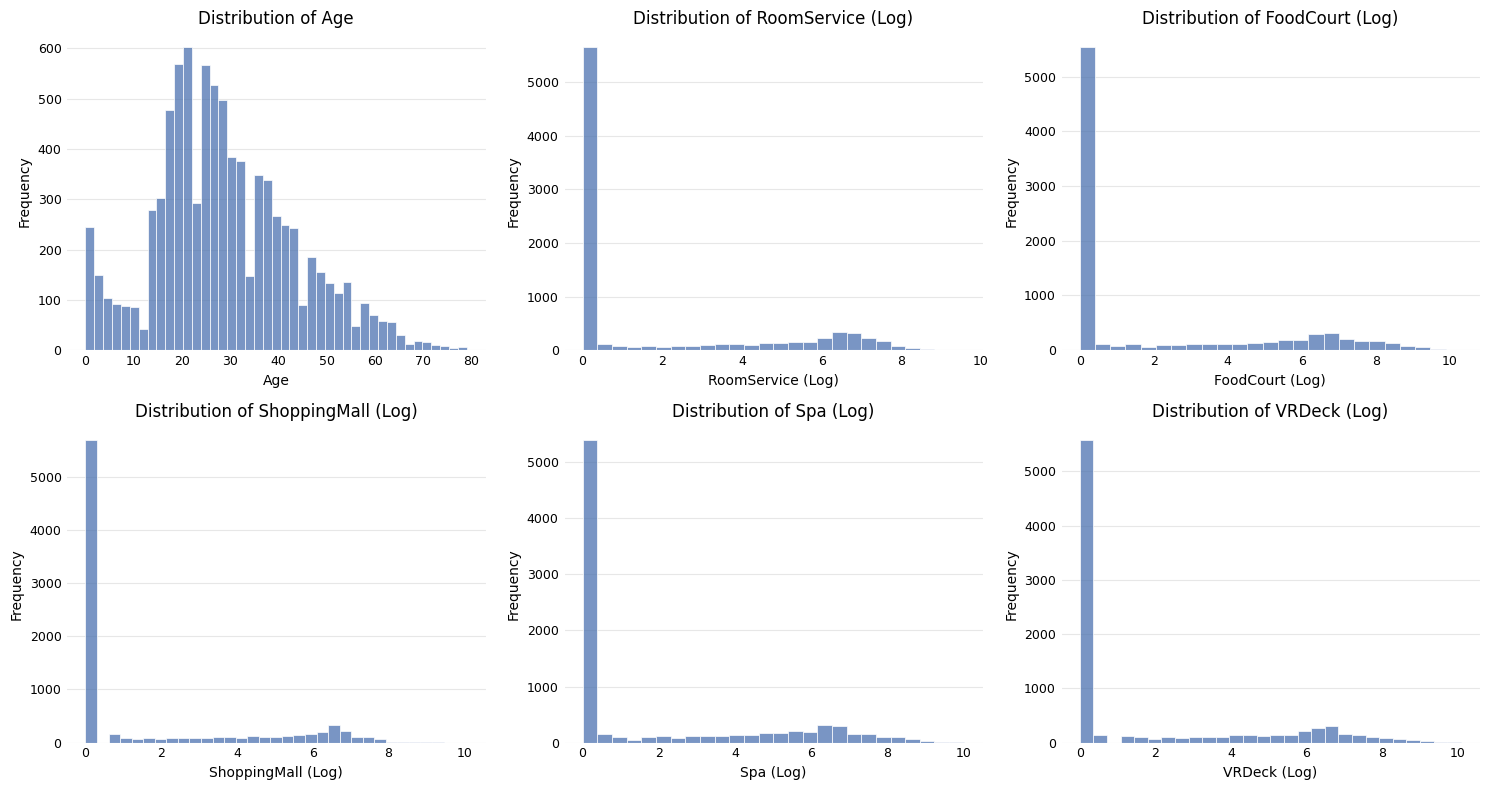

Percentage of zeros in RoomService for each passenger group: 57.20%
Percentage of zeros in FoodCourt for each passenger group: 56.89%
Percentage of zeros in ShoppingMall for each passenger group: 57.54%
Percentage of zeros in Spa for each passenger group: 54.79%
Percentage of zeros in VRDeck for each passenger group: 57.49%
Percentage of groups with no luxury spending at all: 30.06%


In [9]:
spending_columns = passengers.select_dtypes(include=["float64"]).columns[1:]
passengers_log = passengers.copy()
passengers_log[spending_columns] = np.log1p(passengers[spending_columns])
new_column_names = {col: f"{col} (Log)" for col in spending_columns}
passengers_log.rename(columns=new_column_names, inplace=True)
plot_numeric_distributions(passengers_log)

passengers["GroupId"] = passengers["PassengerId"].str.split("_").str[0]
group_spending = passengers.groupby("GroupId")[spending_columns].sum()
for column in spending_columns:
    zero_percentage = (group_spending[column] == 0).mean() * 100
    print(
        f"Percentage of zeros in {column} for each passenger group: {zero_percentage:.2f}%"
    )
passengers.drop(columns=["GroupId"], inplace=True)

no_spending = (group_spending == 0).all(axis=1)
percentage_no_spending = no_spending.mean() * 100
print(
    f"Percentage of groups with no luxury spending at all: {percentage_no_spending:.2f}%"
)

Observations:
- The distributions of luxury spending features are heavily skewed. A few people spent a lot, while most spent little or nothing at all.
- Many passengers had no luxury spending, resulting in a large number of zeros.
- No entry errors are visible.

## Entry Errors and Anomalies of Categorical Variables

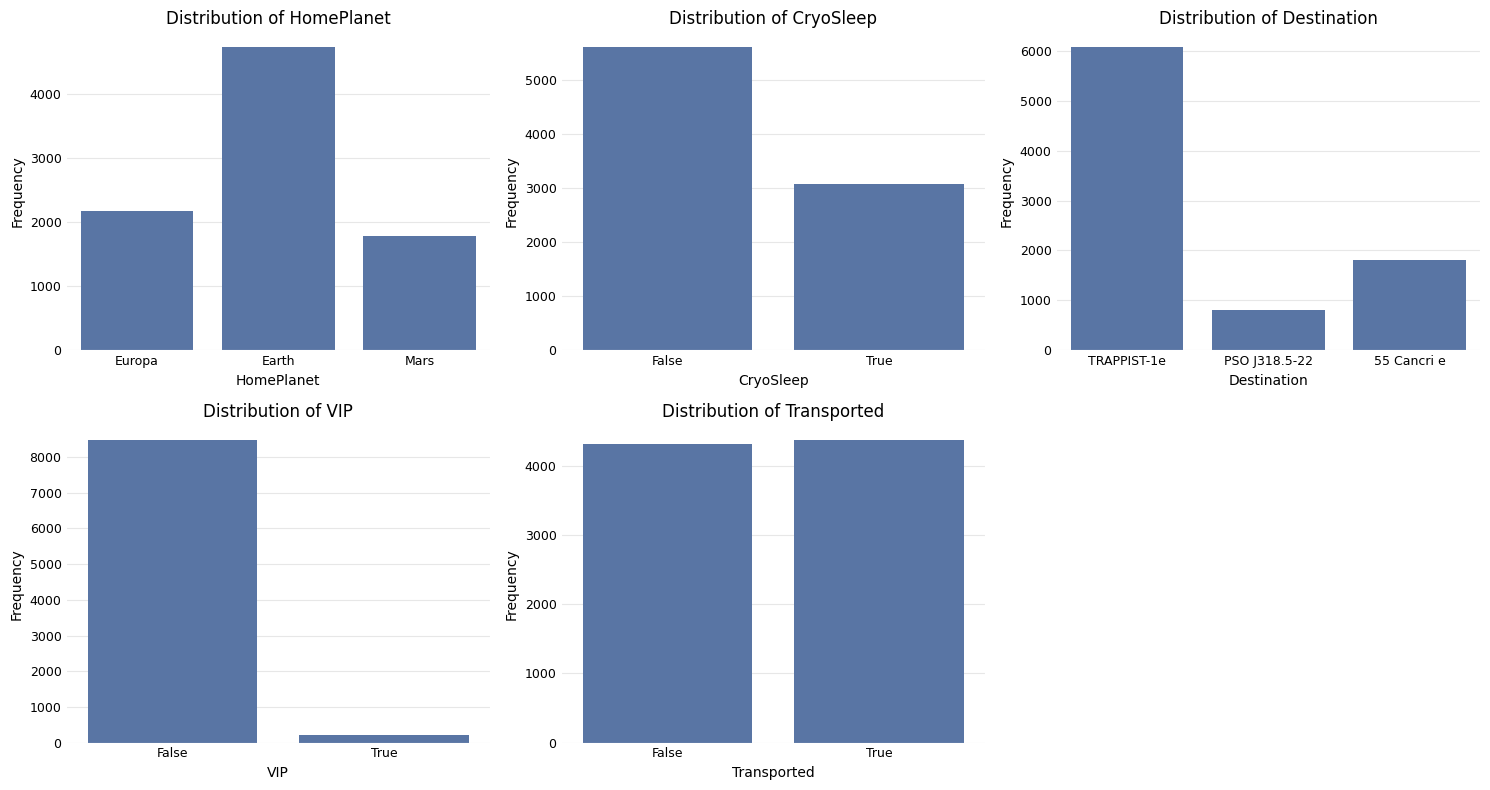

In [10]:
passengers_for_cleaning_and_eda = passengers.drop(
    columns=["PassengerId", "Cabin", "Name"]
)
plot_categorical_distributions(passengers_for_cleaning_and_eda)

Observations:
- Nothing unusual.

## Summary

The training dataset is relatively clean, though about 24% of the rows contain missing values. I have taken two approaches to address this:

- By inspecting the dataframe, I found the following patterns: if a passenger is in CryoSleep, their spending values are 0; passengers in the same group are traveling from the same planet; children (below 13 years old) do not spend any money; and people in the same group are likely to travel in the same cabin, though this is not guaranteed.
- Additionally, I selected passengers with similar categorical information and filled in missing values with the most common value within that subset.

Additional findings:

- The features "PassengerId", "Cabin", and "Name" require further feature engineering to extract useful information, which will be done in the feature engineering section.
- No entry errors or anomalies were detected, but all numeric predictors, except for age, are heavily skewed with extreme outliers and many zero values. Since outliers can cause problems for any model, I will consider dropping them at the machine learning stage of the project.
- The target variable has been converted to object type.

# EDA

The main objectives for this part of the notebook are:

- Explore the dataset through bivariate analysis.
- Document relevant findings.

## Target Variable

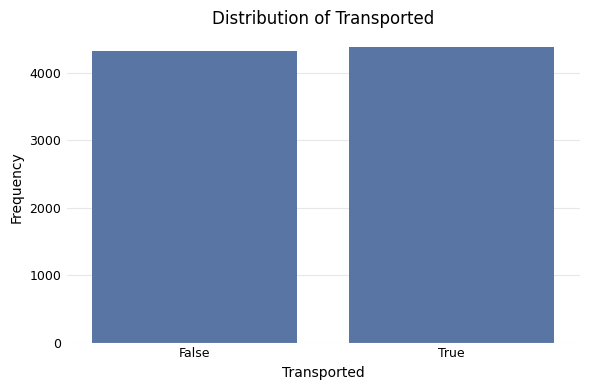

In [11]:
sns.countplot(data=passengers, x="Transported", zorder=2)
plt.title("Distribution of Transported")
plt.ylabel("Frequency")
plt.tight_layout()

Observations:

- The target feature is balanced.

## Relationships Between Target and Predictors

Important takeaways will be written out at the end of this sub-section.

The Phik ($\phi_K$) correlation coefficient measures the strength of association between variables, similar to the Pearson correlation for continuous data, but it is adapted for categorical and mixed data types (it converts numeric variables into categorical ones). $\phi_K$ values range from 0 to 1, where 0 indicates no association and 1 indicates a perfect association. This measure does not indicate the direction of the influence.

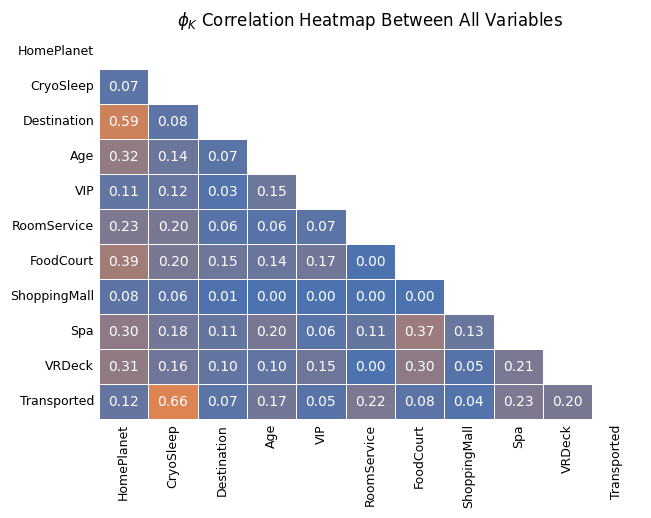

In [12]:
phik_heatmap(passengers_for_cleaning_and_eda)

### Relationships Between Target and Categorical Predictors

The chi-square test will be used to assess whether there are significant differences between two groups of categorical data. If there are multiple groups, the test would not specify which exact groups differ only that there is atleast one statistically significant difference.

Assumptions for the chi-square hypothesis test:
- Independence: Each traveler has a unique ID, meaning that their data points are independent of each other and not related to other passengers entries.
- Expected Frequency at least 5: The counts of each category in each group are visible from the bar plots on the left. The assumption is valid for all relationships. 
- Categorical Data: Our data is categorical.
- Adequate Sample Size: Since the second assumption (expected frequency) is met, the fourth assumption is generally not a concern.

Null Hypothesis (H0): There is no association between the predictor and the target variable.

Alternative Hypothesis (H1): There is an association between the predictor and the target variable.

Significance level of 0.05 will be used to test these hypotheses. If the p-value calculated from the chi-square test is less than 0.05, we will reject the null hypothesis in favor of the alternative hypothesis.

Example: In the case of HomePlanet and being transported (shown below), the p-value is below the significance level. We reject the null hypothesis and conclude that there is at least one statistically significant difference between passengers home planet and whether or not they were transported.

It is important to note that throughout the project, all associations will be statistically significant due to the large dataset. However, in some cases, the observed differences may be very small and not practically meaningful. 

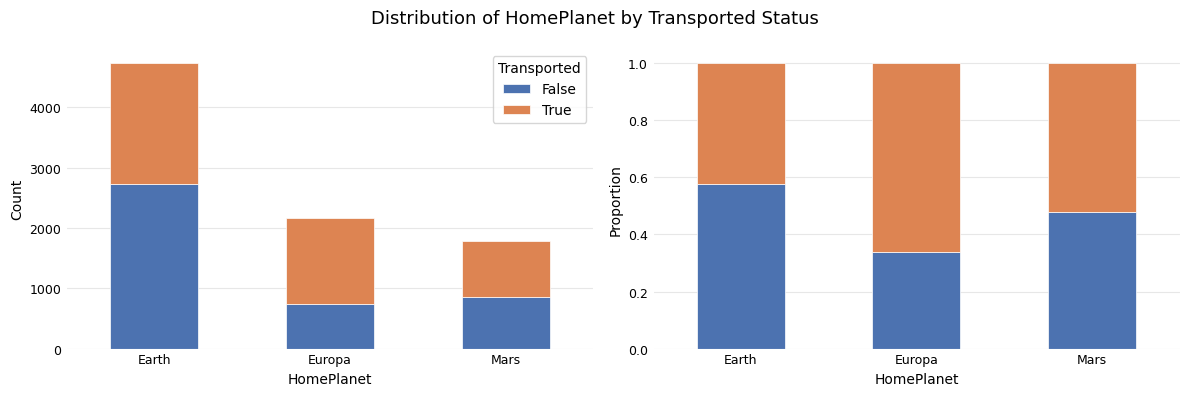

HomePlanet - Transported:
Chi-Square test p-value: 0.00



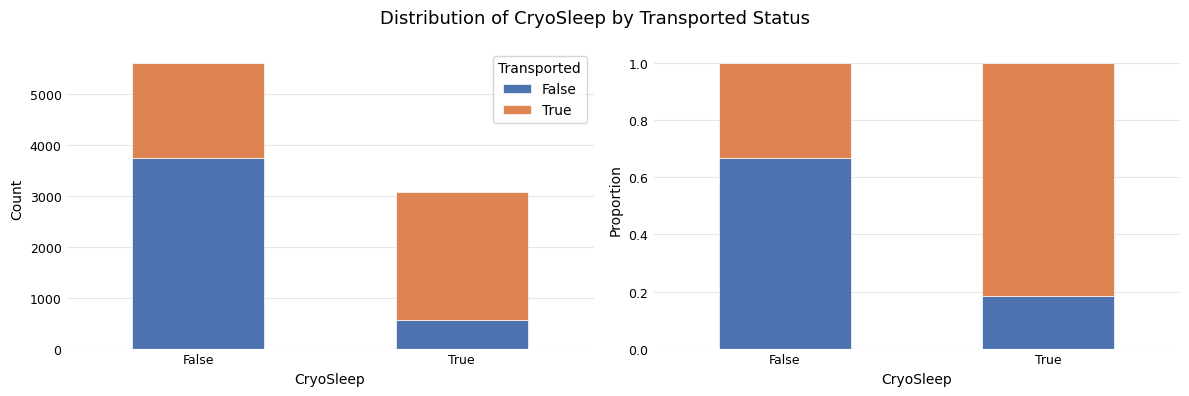

CryoSleep - Transported:
Chi-Square test p-value: 0.00



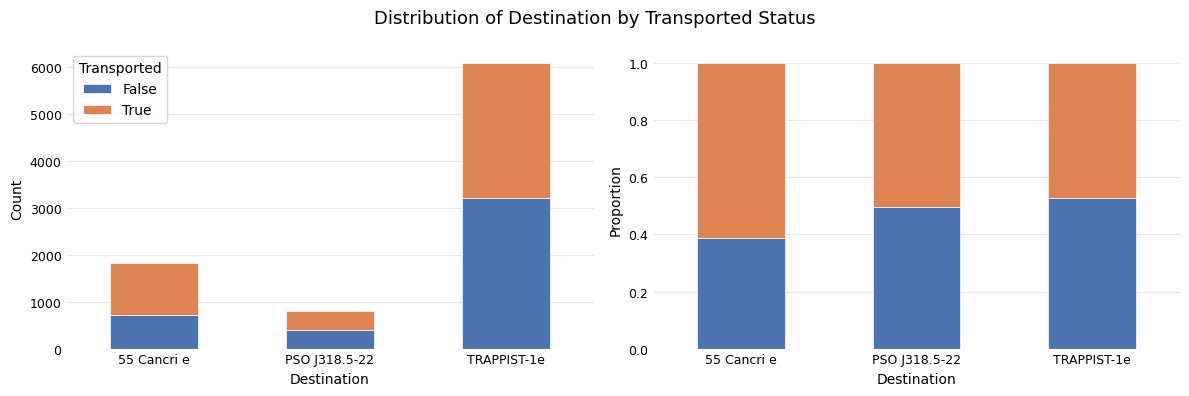

Destination - Transported:
Chi-Square test p-value: 0.00



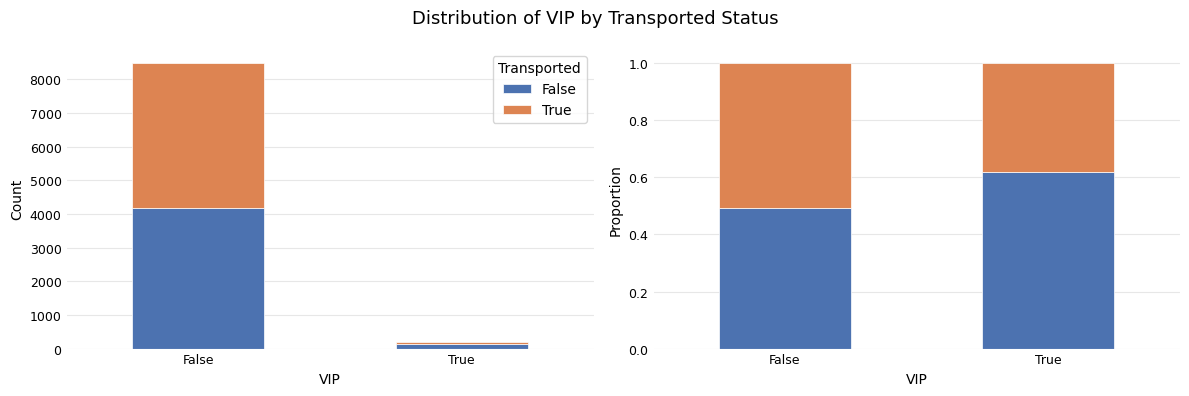

VIP - Transported:
Chi-Square test p-value: 0.00



In [13]:
categorical_relationships(passengers_for_cleaning_and_eda, "Transported")

### Relationship Between Target and Numeric Age

Most of the numeric features have many zeros and are heavily skewed, so I won't visualize them. If they are related to the target variable or not can be seen in the phik correlation heatmap.

The bootstrap hypothesis test will be used to determine if there is a significant difference in medians between the transported and non-transported segments.

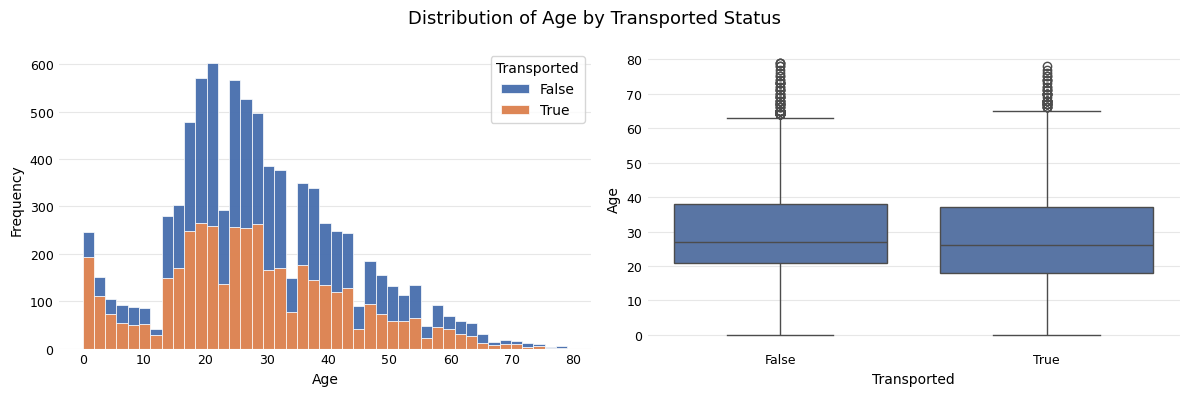

Age - Transported:
Bootstrap hypothesis test p-value: 0.00


In [14]:
age_df = passengers[["Age", "Transported"]]
numeric_relationships(age_df, "Transported")

## Summary

Descriptions of the relationships between target and predictors:

- The most predictive feature for transportation appears to be whether or not a person was in CryoSleep, with passengers in CryoSleep being much more likely to be transported.
- Luxury spending (except for food court and shopping mall) also provides some indication of transportation. 
- Other features show low predictive power.

This could suggest that individuals in confined spaces, such as those in CryoSleep or staying in their rooms, spa, or VR deck, may have been unable to take actions to save themselves. Alternatively, certain sections of the ship may have been more affected by the incident. To verify this, the next step could be to examine whether spending at certain locations (and thus being more likely to be in those areas at the time of the accident) is associated with a higher or lower chance of transportation.

Visiting the food court and shopping mall seems to offer equal chances of survival, with some individuals making decisions that saved them while others made choices that led to being transported off the ship. Unlike the real Titanic, a person's class no longer appears to be a factor in survival. This could be coincidental, as the cosmic anomaly may have occurred suddenly, without allowing anyone's wealth to influence the outcome.

# Feature Engineering

The main objectives for this part of the notebook are:

- Develop a set of features that have a potential to improve model's performance.
- Investiage the relationships between new features and the target.

I will assess whether these efforts were beneficial at the end of the machine learning section.

## Feature Creation

Being part of a group or family may affect a passenger's chances of survival, as they would be more likely to receive and assist with help:

- GroupSize: The number of people traveling together in each group.
- IsInGroup: A binary feature indicating whether a passenger is part of a group.
- FamilySize: Family ties are likely stronger than group connections. FamilySize is based on the number of people with the same last name within a group.
- HasFamily: A binary indicator showing whether a passenger is traveling with family.

Wealth may also play a role in survival. Wealthy passengers may travel together, although some may not spend money, potentially hiding the effect of wealth:

- LuxurySpending: The total luxury spending for each passenger.
- Average spending for a group: Luxury spending for each spending type in a group.

Since the incident could be linked to specific areas of the ship, knowing where passengers were residing could be very important:

- Deck: The deck where the passenger's cabin was located.
- CabinNumber: The specific cabin number.
- Side: Indicates whether the cabin was on the port or starboard sde of the ship.

In [15]:
passengers_new_features = passengers.copy()
spending_columns = passengers.select_dtypes(include=["float64"]).columns[1:].to_list()
passengers_new_features["GroupId"] = passengers_new_features["PassengerId"].str[:4]
passengers_new_features["GroupSize"] = (
    passengers_new_features.groupby("GroupId")["GroupId"]
    .transform("count")
    .astype("float64")
)
passengers_new_features["IsInGroup"] = passengers_new_features["GroupSize"].apply(
    lambda x: 1 if x > 1 else 0
)

passengers_new_features["FamilyId"] = (
    passengers_new_features["GroupId"]
    + "_"
    + passengers_new_features["Name"].str.split().str[-1]
)
passengers_new_features["FamilySize"] = passengers_new_features.groupby("FamilyId")[
    "FamilyId"
].transform("count")
passengers_new_features["HasFamily"] = passengers_new_features["FamilySize"].apply(
    lambda x: 1 if x > 1 else (0 if x == 1 else np.nan)
)

passengers_new_features["LuxurySpending"] = passengers_new_features[
    spending_columns
].sum(axis=1)
spending_columns.append("LuxurySpending")
group_spending = passengers_new_features.groupby("GroupId")[spending_columns].mean()
group_spending.columns = [f"Avg{col}" for col in spending_columns]
passengers_new_features = passengers_new_features.merge(
    group_spending, on="GroupId", how="left"
)

deck_mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8}
passengers_new_features["Deck"] = passengers["Cabin"].str[:1].map(deck_mapping)
passengers_new_features["CabinNumber"] = (
    passengers["Cabin"].str[2:-2].apply(pd.to_numeric)
)
passengers_new_features["Side"] = passengers["Cabin"].str[-1:]

columns_to_change = ["IsInGroup", "HasFamily"]
for column in columns_to_change:
    passengers_new_features[column] = passengers_new_features[column].astype("object")
    passengers_new_features[column] = passengers_new_features[column].replace(
        {0: "No", 1: "Yes"}
    )

passengers_new_features.drop(
    columns=["GroupId", "FamilyId", "PassengerId", "Cabin", "Name"], inplace=True
)
passengers.drop(columns=["PassengerId", "Cabin", "Name"], inplace=True)
passengers_new_features.iloc[:, 10:].head()

,Transported,GroupSize,IsInGroup,FamilySize,HasFamily,LuxurySpending,AvgRoomService,AvgFoodCourt,AvgShoppingMall,AvgSpa,AvgVRDeck,AvgLuxurySpending,Deck,CabinNumber,Side
0,False,1.0,No,1.0,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,P
1,True,1.0,No,1.0,No,736.0,109.0,9.0,25.0,549.0,44.0,736.0,6.0,0.0,S
2,False,2.0,Yes,2.0,Yes,10383.0,21.5,2429.5,185.5,5022.0,121.0,7779.5,1.0,0.0,S
3,False,2.0,Yes,2.0,Yes,5176.0,21.5,2429.5,185.5,5022.0,121.0,7779.5,1.0,0.0,S
4,True,1.0,No,1.0,No,1091.0,303.0,70.0,151.0,565.0,2.0,1091.0,6.0,1.0,S


## Predictability Check

Important takeaways will be written out at the end of this sub-section.

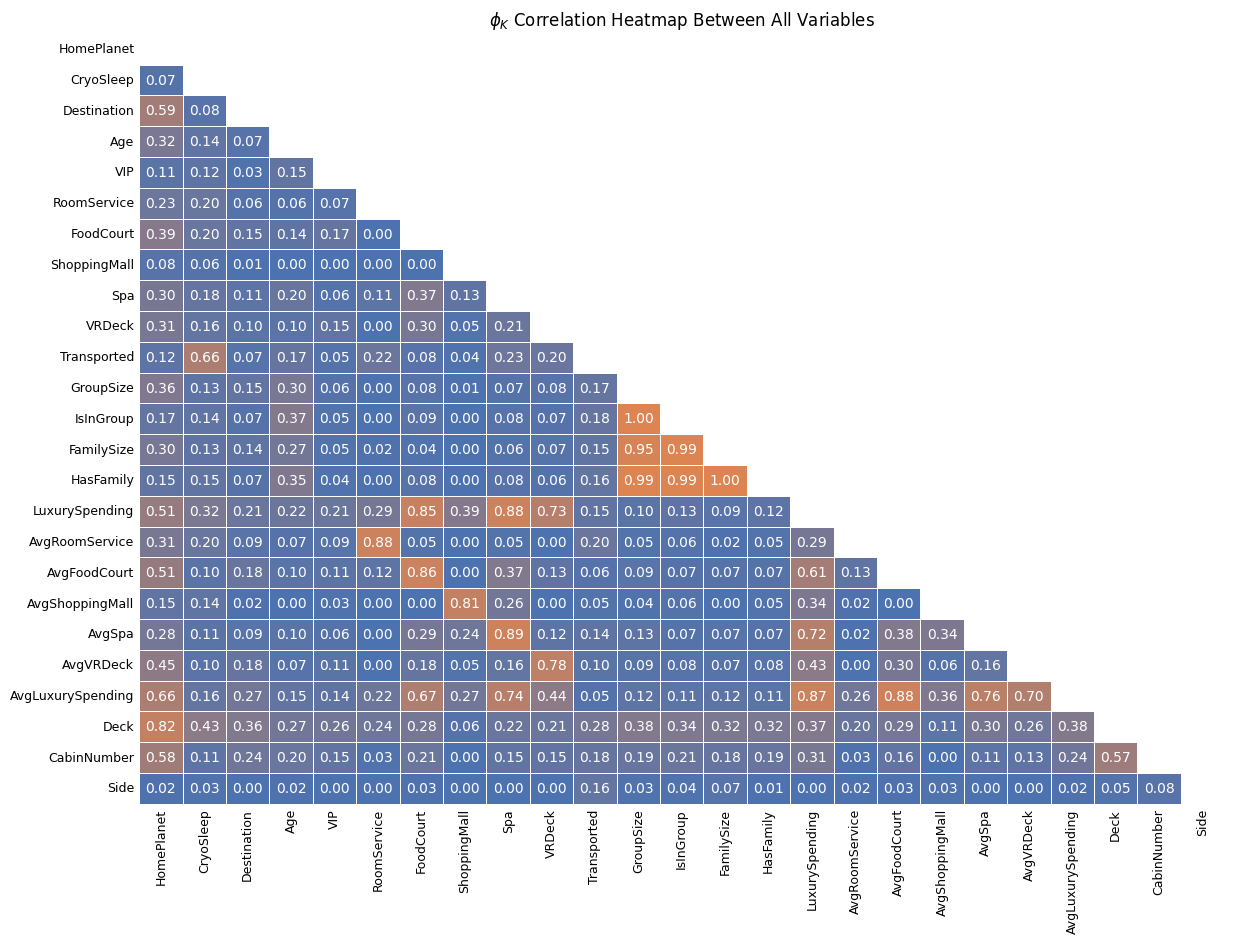

In [16]:
phik_heatmap(passengers_new_features, 2)

### Relationships Between Target and New Categorical Predictors

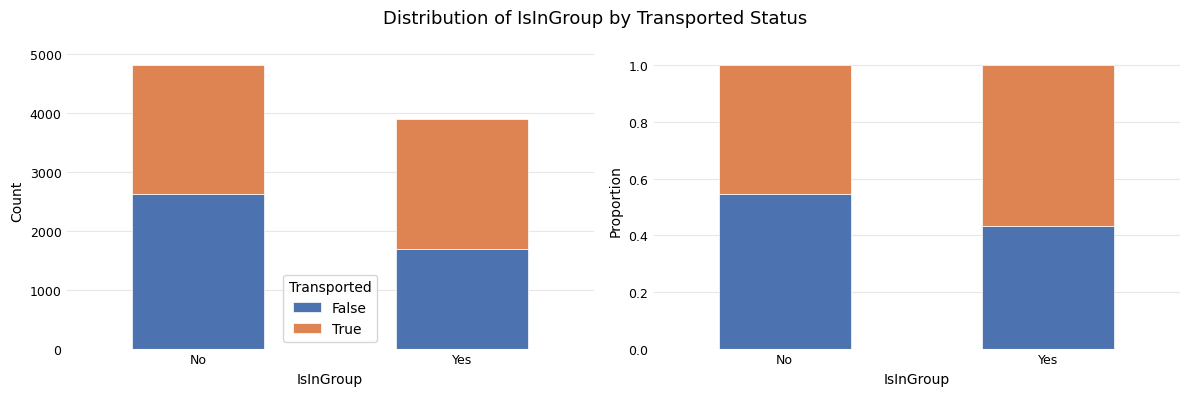

IsInGroup - Transported:
Chi-Square test p-value: 0.00



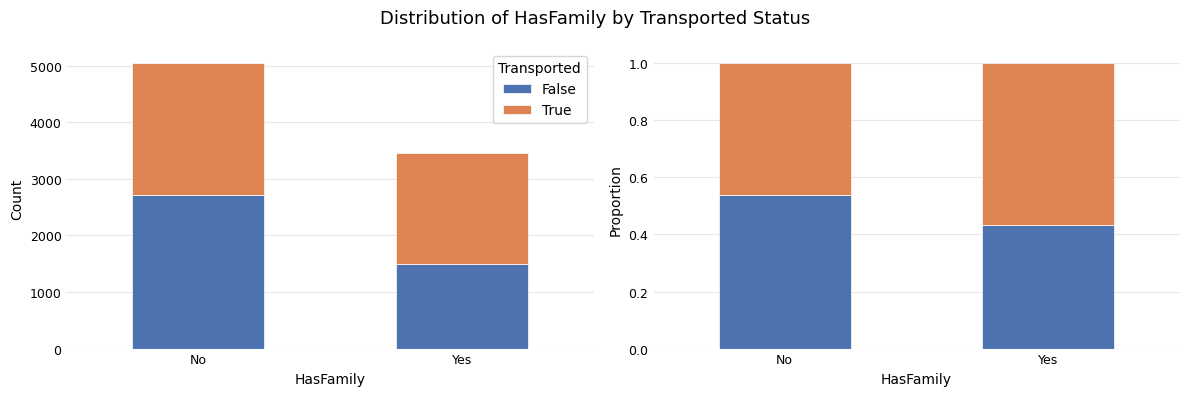

HasFamily - Transported:
Chi-Square test p-value: 0.00



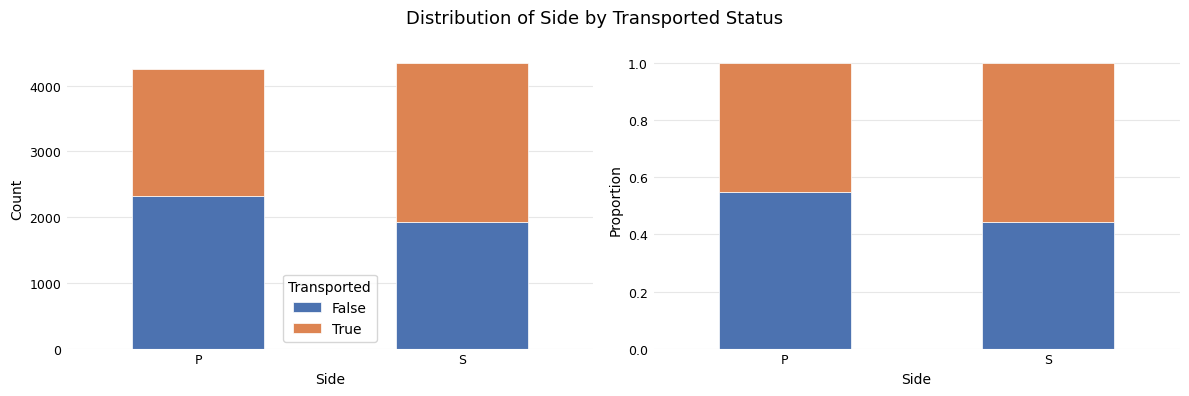

Side - Transported:
Chi-Square test p-value: 0.00



In [17]:
categorical_relationships(passengers_new_features.iloc[:, 10:], "Transported")

### Relationships Between Target and New Numeric Predictors

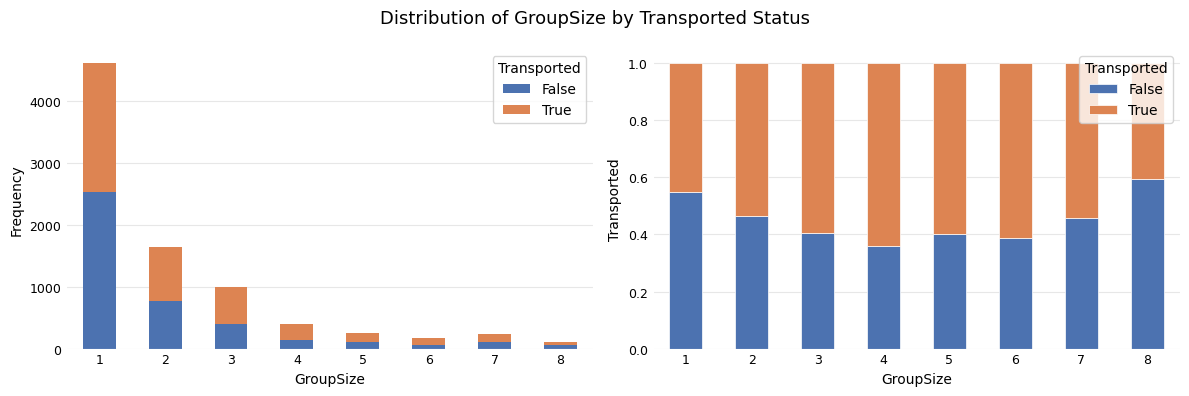

GroupSize - Transported:
Bootstrap hypothesis test p-value: 0.00


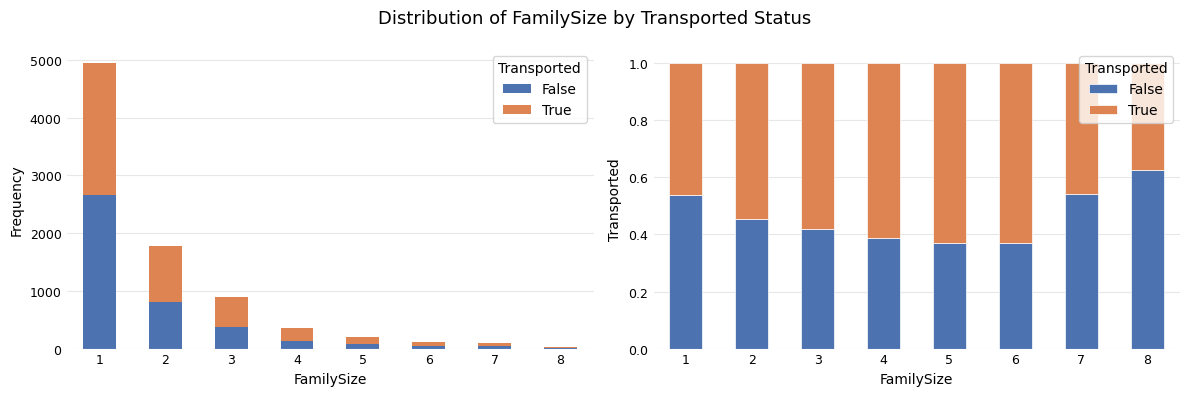

FamilySize - Transported:
Bootstrap hypothesis test p-value: 0.00


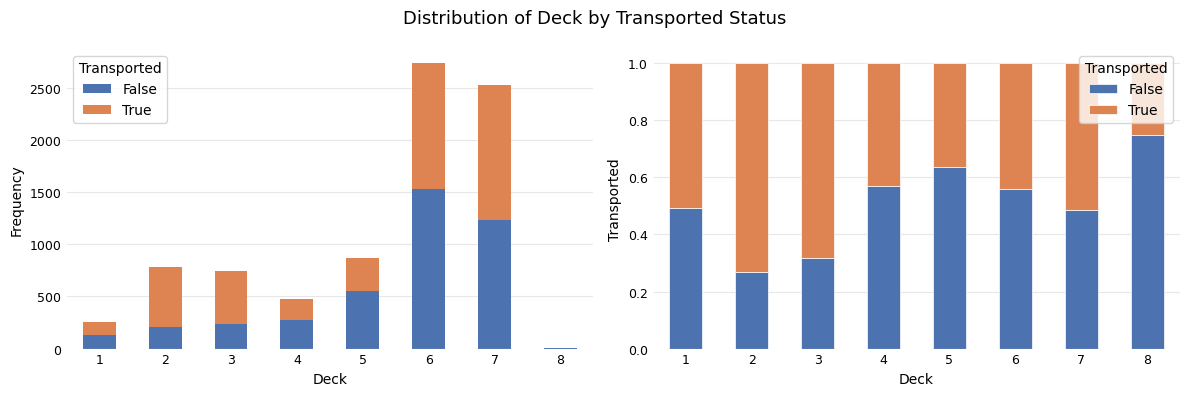

Deck - Transported:
Bootstrap hypothesis test p-value: 0.00


In [18]:
ordinal_relationships(
    passengers_new_features[["GroupSize", "FamilySize", "Deck", "Transported"]],
    "Transported",
)

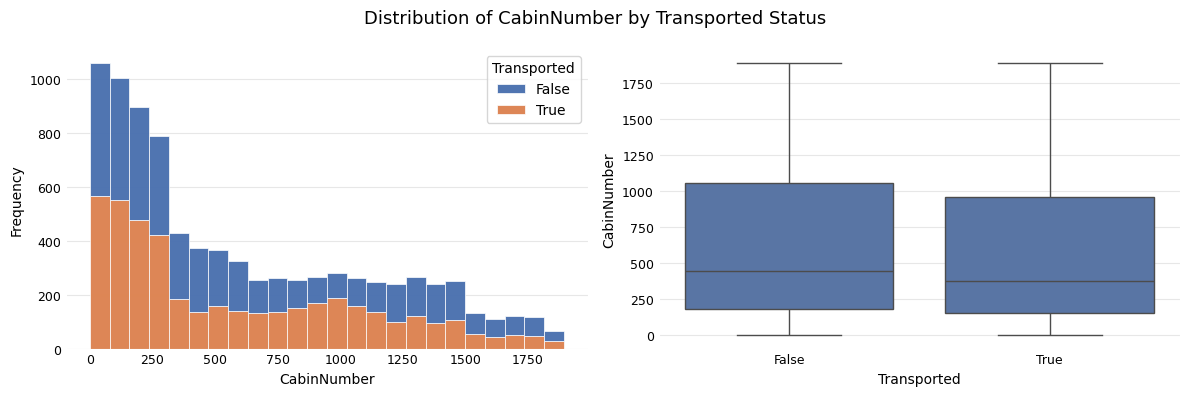

CabinNumber - Transported:
Bootstrap hypothesis test p-value: 0.00


In [19]:
numeric_relationships(
    passengers_new_features[["CabinNumber", "Transported"]], "Transported"
)

## Summary

Descriptions of the relationships between target and predictors:

- Except for some spending information, most of the engineered features are associated with transportation.
 - Much of the information related to group membership and spending patterns is highly correlated, I will most likely have to remove it to prevent increased model complexity and overfitting.
- Residence location does not a clear indicator of transportation.
- Most of the people were residing on the upper decks (floors), and the rate of transportation from those decks is lower compared to the lower decks.
- Having family or being part of a group improves the chance of survival very slightly.

Passengers likely stayed on the lower decks, as most were registered there, while the staff were probably on the upper levels. The staff may have been in their quarters during the event or assisting passengers when they got caught in the incident. Another possibility is that the upper decks were more affected because cryo-sleep passengers or some of the entertainment areas were located there. To better understand the ship's layout, I could analyze the relationships between deck location and other features. It would also be helpful to know whether individuals were part of the ship's staff and where they were during the incident.

# Machine Learning

The main objectives for this part of the notebook are:

- Test different models to find the one that performs the best.
- Refine the selected model and predict the test dataset.
- Practice using AutoML.

Since Kaggle bases its evaluation on accuracy and the labels are balanced, accuracy will be the primary metric for model evaluation.

## Baseline with Dummy Classifier

In [20]:
scoring = {
    "accuracy": "accuracy",
    "f1": make_scorer(f1_score, pos_label=1),
    "precision": make_scorer(precision_score, pos_label=1),
    "recall": make_scorer(recall_score, pos_label=1),
}
X = passengers.drop(columns="Transported")
y = passengers["Transported"]
y_encoded = LabelEncoder().fit_transform(y)
strategies = ["stratified", "most_frequent", "prior", "uniform"]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
results = []
for strategy in strategies:
    dummy_clf = DummyClassifier(strategy=strategy)
    cv_scores = cross_validate(
        dummy_clf, X, y_encoded, cv=cv, scoring=scoring, return_train_score=True
    )
    result = {
        "model": strategy,
        "validation_accuracy": cv_scores["test_accuracy"].mean(),
        "train_accuracy": cv_scores["train_accuracy"].mean(),
        "f1": cv_scores["test_f1"].mean(),
        "precision": cv_scores["test_precision"].mean(),
        "recall": cv_scores["test_recall"].mean(),
    }
    results.append(result)
dummy_results = pd.DataFrame(results).set_index("model")
dummy_results.index.name = None
dummy_results

,validation_accuracy,train_accuracy,f1,precision,recall
stratified,0.506612,0.499885,0.506102,0.510370,0.502053
most_frequent,0.503624,0.503624,0.669880,0.503624,1.000000
prior,0.503624,0.503624,0.669880,0.503624,1.000000
uniform,0.494996,0.497699,0.498004,0.498989,0.497264


Observations:

- All of the basic classifiers are able to predict 50% of labels.

## Model Selection

Data preprocessing involves separate pipelines for different types of models. For tree-based models like Random Forest, XGBoost, CatBoost, and LightGBM, categorical features are target encoded. For linear models (Logistic Regression and SVM), numeric features undergo log transformation and scaling, while categorical features are one-hot encoded, with one category from each variable dropped to avoid multicollinearity. KNN models follow a similar preprocessing pipeline but use full one-hot encoding for categorical variables. 

I also iteratively explored additional methods for imputation, encoding, dimentionality reduction and these efforts are documented below.

### Original features

My initial approach was to evaluate how well different models performed using only the original features. I noticed that tree-based models were less effective compared to others and found that imputing missing values was crucial, even though these models can handle missing data. Imputing missing numeric values improved tree based model performances by about 8%.
 
Other steps that did not lead to meaningful improvements included:

- Different imputation methods for numeric features (KNN vs. mean) showed no effect.
- For non free based model PCA did not provide any benefit.
- Excluding any features did not improve any models effectiveness.
- Keeping all categories for linear and SVM models produced no additional benefit.
- For tree based models one-hot encoding and target encoding yielded similar results.

In [21]:
warnings.filterwarnings("ignore", category=FutureWarning)
models = {
    "LogisticRegression": LogisticRegression(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=5),
    "XGBoost": XGBClassifier(random_state=5),
    "CatBoost": CatBoostClassifier(random_state=5, verbose=0),
    "LightGBM": LGBMClassifier(random_state=5, verbose=0),
}
numeric_features = X.select_dtypes(include="number").columns.tolist()
categorical_features = X.select_dtypes(include="object").columns.tolist()
numeric_inputter = KNNImputer()
preprocessor_tree_based = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    ("imputer", numeric_inputter),
                ]
            ),
            numeric_features,
        ),
        (
            "cat",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("encoder", TargetEncoder()),
                ]
            ),
            categorical_features,
        ),
    ]
)
preprocessor_linear_svm = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    ("imputer", numeric_inputter),
                    ("log", FunctionTransformer(np.log1p, validate=True)),
                    ("scaler", StandardScaler()),
                ]
            ),
            numeric_features,
        ),
        (
            "cat",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("encoder", OneHotEncoder(drop="first")),
                ]
            ),
            categorical_features,
        ),
    ]
)
preprocessor_knn = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    ("imputer", numeric_inputter),
                    ("log", FunctionTransformer(np.log1p, validate=True)),
                    ("scaler", StandardScaler()),
                ]
            ),
            numeric_features,
        ),
        (
            "cat",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("encoder", OneHotEncoder()),
                ]
            ),
            categorical_features,
        ),
    ]
)
results = []
for model_name, single_model in models.items():
    if model_name in ["LogisticRegression", "SVM"]:
        pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor_linear_svm),
                ("classifier", single_model),
            ]
        )
    elif model_name == "KNN":
        pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor_knn),
                ("classifier", single_model),
            ]
        )

    else:
        pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor_tree_based),
                ("classifier", single_model),
            ]
        )
    cv_scores = cross_validate(
        pipeline,
        X,
        y_encoded,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
    )
    result = {
        "model": model_name,
        "validation_accuracy": cv_scores["test_accuracy"].mean(),
        "train_accuracy": cv_scores["train_accuracy"].mean(),
        "f1": cv_scores["test_f1"].mean(),
        "precision": cv_scores["test_precision"].mean(),
        "recall": cv_scores["test_recall"].mean(),
    }
    results.append(result)
results_df = pd.DataFrame(results).set_index("model")
results_df.index.name = None
display(results_df)

,validation_accuracy,train_accuracy,f1,precision,recall
LogisticRegression,0.774992,0.774934,0.782211,0.763117,0.802425
SVM,0.794547,0.801823,0.800810,0.782791,0.819780
KNN,0.753709,0.814822,0.749534,0.768584,0.731609
RandomForest,0.789140,0.931267,0.789996,0.792661,0.787574
GradientBoosting,0.793167,0.810997,0.803278,0.771219,0.838285
XGBoost,0.790521,0.885368,0.795187,0.783126,0.807674
CatBoost,0.796387,0.842229,0.803109,0.782765,0.824576
LightGBM,0.793627,0.852525,0.801168,0.778277,0.825492


Observations:

- Models are performing similarly, with an accuracy of around 79%.

### Additional Features

The additional preprocessing steps did not provide any substantial improvements:

- For liner, SVM and KNN models PCA showed only a very minor improvement in performance. Keeping all categories for encoding resulted in a very small boost.
- For three based models label encoding was only very slightly better than one-hot encoding.
- Dropping a few of the least predictive features decreased the performance of simpler models but had little impact on more complex ones.
- Using the median for numeric imputation performed marginally better than mean and KNN imputation.

In [22]:
X_new_features = passengers_new_features.drop(columns="Transported")
models = {
    "LogisticRegression": LogisticRegression(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=5),
    "XGBoost": XGBClassifier(random_state=5),
    "CatBoost": CatBoostClassifier(random_state=5, verbose=0),
    "LightGBM": LGBMClassifier(random_state=5, verbose=0),
}
numeric_with_new_feat = X_new_features.select_dtypes(include="number").columns.tolist()
categorical_with_new_feat = X_new_features.select_dtypes(
    include="object"
).columns.tolist()
numeric_inputter = SimpleImputer(strategy="mean")
preprocessor_tree_based = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    ("imputer", numeric_inputter),
                ]
            ),
            numeric_with_new_feat,
        ),
        (
            "cat",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("encoder", TargetEncoder()),
                ]
            ),
            categorical_with_new_feat,
        ),
    ]
)
preprocessor_linear_svm = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    ("imputer", numeric_inputter),
                    ("log", FunctionTransformer(np.log1p, validate=True)),
                    ("scaler", StandardScaler()),
                ]
            ),
            numeric_with_new_feat,
        ),
        (
            "cat",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("encoder", OneHotEncoder(drop="first")),
                ]
            ),
            categorical_with_new_feat,
        ),
    ]
)
preprocessor_knn = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    ("imputer", numeric_inputter),
                    ("log", FunctionTransformer(np.log1p, validate=True)),
                    ("scaler", StandardScaler()),
                ]
            ),
            numeric_with_new_feat,
        ),
        (
            "cat",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("encoder", OneHotEncoder()),
                ]
            ),
            categorical_with_new_feat,
        ),
    ]
)
results = []
for model_name, single_model in models.items():
    if model_name in ["LogisticRegression", "SVM"]:
        pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor_linear_svm),
                ("pca", PCA(n_components="mle")),
                ("classifier", single_model),
            ]
        )
    elif model_name == "KNN":
        pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor_knn),
                ("pca", PCA(n_components="mle")),
                ("classifier", single_model),
            ]
        )

    else:
        pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor_tree_based),
                ("classifier", single_model),
            ]
        )
    cv_scores = cross_validate(
        pipeline,
        X_new_features,
        y_encoded,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
    )
    result = {
        "model": model_name,
        "validation_accuracy": cv_scores["test_accuracy"].mean(),
        "train_accuracy": cv_scores["train_accuracy"].mean(),
        "f1": cv_scores["test_f1"].mean(),
        "precision": cv_scores["test_precision"].mean(),
        "recall": cv_scores["test_recall"].mean(),
    }
    results.append(result)
results_df = pd.DataFrame(results).set_index("model")
results_df.index.name = None
display(results_df)

,validation_accuracy,train_accuracy,f1,precision,recall
LogisticRegression,0.775682,0.778615,0.781121,0.767955,0.794884
SVM,0.795237,0.809272,0.801711,0.782665,0.821836
KNN,0.767973,0.837513,0.765808,0.778705,0.753534
RandomForest,0.797768,0.999597,0.793875,0.816058,0.772955
GradientBoosting,0.803060,0.825089,0.809653,0.788679,0.831889
XGBoost,0.801795,0.953382,0.801758,0.807886,0.795799
CatBoost,0.815138,0.890113,0.818588,0.809281,0.828230
LightGBM,0.807317,0.904550,0.810701,0.802350,0.819323


Observations:
- Of all models tested, CatBoost showed the best performance.

Impact:
- CatBoost is selected for further refinements.

## Model Tuning

To achieve better classification effectiveness:
- I iteratively dropped the least important features based on SHAP feature importance to reduce overfitting and noise, but this did not produce noticeable improvements and at a certain point only started to lover the validation accurasy with some reduction in overfitting.
- Tried removing outliers from the spending features based on excluding the largest 1% of values, but this resulted only in a decreased performance.
- The most beneficial step was filling in missing values during the data cleaning stage, which improved classification accuracy on the test set by around 1%.

To find the best hyperparameters I have used bayesian optimization with a wide range of hyperparameters for 100 iterations hoping to reduce overfitting.

Best Hyperparameters: {'depth': 4, 'learning_rate': 0.018778630005364283, 'l2_leaf_reg': 64.75789039585669, 'iterations': 1499, 'subsample': 0.6013530536818925, 'colsample_bylevel': 0.7226637943456466, 'bagging_temperature': 0.22416278871601014}


,validation_accuracy,train_accuracy,f1,precision,recall
CatBoost,0.811343,0.833976,0.8174,0.797439,0.838509


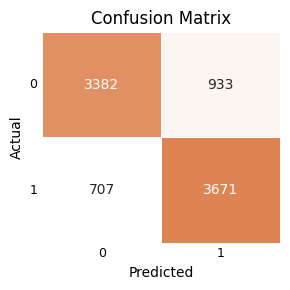

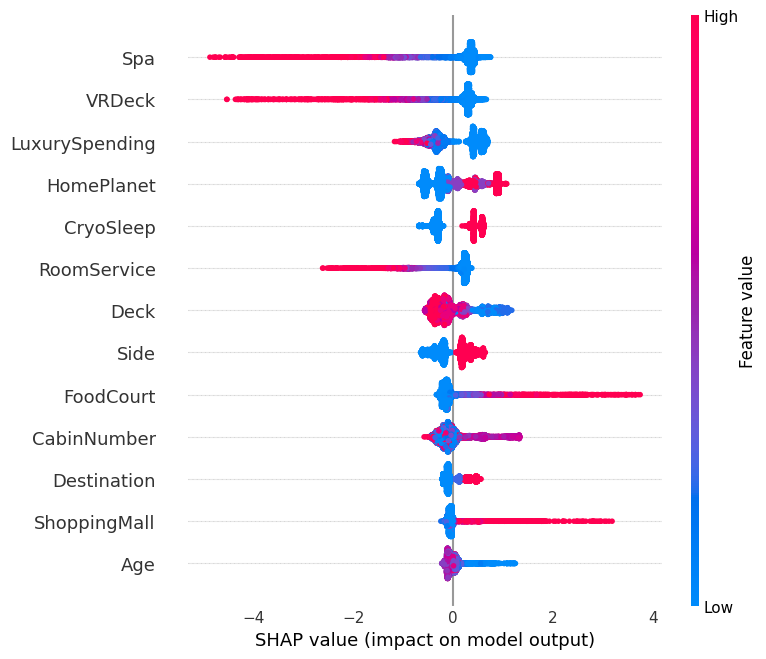

In [23]:
X_catboost = X_new_features.copy()
columns_to_drop = [
    "FamilySize",
    "AvgShoppingMall",
    "AvgLuxurySpending",
    "VIP",
    "HasFamily",
    "IsInGroup",
    "GroupSize",
    "AvgSpa",
    "AvgVRDeck",
    "AvgRoomService",
    "AvgFoodCourt",
]
X_catboost.drop(columns=columns_to_drop, inplace=True, errors="ignore")


def objective(trial: optuna.trial.Trial) -> float:
    """
    Optimize the CatBoostClassifier hyperparameters using Optuna.

    Args:
        trial (optuna.trial.Trial): A single trial object which provides
        suggestions for hyperparameters.

    Returns:
        float: The mean accuracy score obtained through cross-validation.
    """
    param = {
        "depth": trial.suggest_int("depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 10, 80),
        "iterations": trial.suggest_int("iterations", 200, 1800),
        "subsample": trial.suggest_float("subsample", 0.4, 1),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 0.9),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_state": 5,
    }
    model = CatBoostClassifier(**param, verbose=0)
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor_tree_based),
            ("classifier", model),
        ]
    )
    score = cross_val_score(
        pipeline, X_catboost, y_encoded, cv=cv, scoring="accuracy"
    ).mean()
    return score


optuna.logging.set_verbosity(optuna.logging.ERROR)
numeric_with_new_feat = X_catboost.select_dtypes(include="number").columns.tolist()
categorical_with_new_feat = X_catboost.select_dtypes(include="object").columns.tolist()
preprocessor_tree_based = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                ]
            ),
            numeric_with_new_feat,
        ),
        (
            "cat",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("encoder", TargetEncoder()),
                ]
            ),
            categorical_with_new_feat,
        ),
    ]
)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1)
print("Best Hyperparameters:", study.best_params)

best_model = CatBoostClassifier(**study.best_params, verbose=0, random_state=5)
final_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_tree_based),
        ("classifier", best_model),
    ]
)
cv_scores = cross_validate(
    final_pipeline,
    X_catboost,
    y_encoded,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
)
result = {
    "model": "CatBoost",
    "validation_accuracy": cv_scores["test_accuracy"].mean(),
    "train_accuracy": cv_scores["train_accuracy"].mean(),
    "f1": cv_scores["test_f1"].mean(),
    "precision": cv_scores["test_precision"].mean(),
    "recall": cv_scores["test_recall"].mean(),
}
results_df = pd.DataFrame([result]).set_index("model")
results_df.index.name = None
display(results_df)

y_pred = cross_val_predict(
    final_pipeline,
    X_catboost,
    y_encoded,
    cv=cv,
)
plot_confusion(y_encoded, y_pred)

final_pipeline.fit(X_catboost, y_encoded)
preprocessor_returned = final_pipeline.named_steps["preprocessor"]
numeric_features = preprocessor_returned.transformers[0][2]
categorical_features = preprocessor_returned.transformers[1][2]
feature_names = np.concatenate([numeric_features, categorical_features])
classifier = final_pipeline.named_steps["classifier"]
X_transformed = preprocessor_returned.transform(X_catboost)
explainer = shap.TreeExplainer(classifier)
shap_values = explainer(X_transformed)
shap.summary_plot(shap_values, features=X_transformed, feature_names=feature_names)

joblib.dump(final_pipeline, "trained_model.pkl");

Observations:
- After tuning the model for 100 iterations, the best hyperparameters with the current features and preprocessing are: {'depth': 7, 'learning_rate': 0.023835569321578196, 'l2_leaf_reg': 24.292507191462, 'iterations': 1301, 'subsample': 0.978360642238864, 'colsample_bylevel': 0.5014425098048687, 'bagging_temperature': 0.633573757114269}. These hyperparameters results in a validation accuracy of 0.817209 and a train accuracy of 0.881111.
- Hyperparameter tuning does not help to reduce overfitting.
- Of the features I engineered, only the features related to a person's residence on the ship (deck, side, and cabin number) and total luxury spending were useful for the model.
- Tree-based models, like CatBoost, can use the same numeric feature multiple times for different splits, pushing these features higher up in importance. As we saw in the EDA, categorical features like "CryoSleep" and "location on the ship" (deck, cabin, side) are among the few indicators of transportation.
- From the SHAP feature importance, we can see how spending in certain locations influences transportation: higher spending in Spa, VRDeck, and RoomService is associated with being safe, while higher spending in the FoodCourt and ShoppingMall is associated with the opposite.

## Final Predictions on Test Dataset

I created a data preprocessing pipeline that incorporates all the useful feature engineering and modifications applied throughout the project. This pipeline will simplify the data preparation process and will be used for model deployment.

In [24]:
def data_preparation(df: pd.DataFrame) -> pd.DataFrame:
    """
    Data cleaning and feature engineering pipeline.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data to be cleaned and prepared.

    Returns:
        pd.DataFrame: DataFrame with various appropriate transformations applied.
    """
    df_prepared = df.copy()
    spending_columns = ["RoomService", "FoodCourt", "Spa", "VRDeck"]
    df_prepared.loc[
        df_prepared["CryoSleep"] == True, spending_columns
    ] = df_prepared.loc[df_prepared["CryoSleep"] == True, spending_columns].fillna(0)

    df_prepared["PassengerGroup"] = df_prepared["PassengerId"].str[:4]
    df_prepared["HomePlanet"] = (
        df_prepared.groupby("PassengerGroup")["HomePlanet"]
        .apply(lambda x: x.ffill().bfill().infer_objects())
        .reset_index(drop=True)
    )
    df_prepared.drop("PassengerGroup", axis=1, inplace=True)

    df_prepared.loc[df_prepared["Age"] <= 13, spending_columns] = df_prepared.loc[
        df_prepared["Age"] <= 13, spending_columns
    ].fillna(0)

    df_prepared["GroupId"] = df_prepared["PassengerId"].str[:4]
    df_prepared["GroupSize"] = (
        df_prepared.groupby("GroupId")["GroupId"].transform("count").astype("float64")
    )

    df_prepared["LuxurySpending"] = df_prepared[spending_columns].sum(axis=1)
    group_spending = df_prepared.groupby("GroupId")[spending_columns].mean()
    group_spending.columns = [f"Avg{col}" for col in spending_columns]
    df_prepared = df_prepared.merge(group_spending, on="GroupId", how="left")

    deck_mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8}
    df_prepared["Deck"] = df_prepared["Cabin"].str[:1].map(deck_mapping)
    df_prepared["CabinNumber"] = df_prepared["Cabin"].str[2:-2].apply(pd.to_numeric)
    df_prepared["Side"] = df_prepared["Cabin"].str[-1:]

    df_prepared.drop(
        columns=["GroupId", "PassengerId", "Cabin", "Name", "VIP"], inplace=True
    )

    return df_prepared


test_passengers_prepared = data_preparation(test_passengers)
loaded_pipeline = joblib.load("trained_model.pkl")
y_pred = loaded_pipeline.predict(test_passengers_prepared)
y_pred_bool = y_pred.astype(bool)
output = pd.DataFrame(
    {"PassengerId": test_passengers["PassengerId"], "Transported": y_pred_bool}
)
output.to_csv("submission.csv", index=False)

Result:
- After testing various model refinements, the best accuracy score I achieved on Kaggle is 0.80430


## AutoML Practice

To evaluate how this model could perform on new and unseen data, I will perform a train-test split on the available data instead of submitting to Kaggle.

In [25]:
%%capture
X_new_features = passengers_new_features.drop(columns="Transported")
y_categorical = y.astype("category")
X_train, X_test, y_train, y_test = train_test_split(
    X_new_features, y_categorical, test_size=0.2, random_state=5
)
y_train = pd.DataFrame(y_train)
h2o.init(verbose=False)
train = h2o.H2OFrame(X_train)
train["target"] = h2o.H2OFrame(y_train)
test = h2o.H2OFrame(X_test)
x = train.columns[:-1]
y = "target"
aml = H2OAutoML(max_runtime_secs=180)
aml.train(x=x, y=y, training_frame=train)

In [26]:
warnings.filterwarnings("ignore", category=H2ODependencyWarning)
preds = aml.leader.predict(test)
pred_labels = preds["predict"].as_data_frame().values.flatten()
accuracy_score(y_test, pred_labels)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


0.7906843013225991

Observations:
- After running for three minutes, AutoML achieved an accuracy very close to what I was getting without feature selection.
- If I increase the AutoML run time or assist it by excluding less useful features, AutoML could potentially match the effectiveness of my manually tuned model.

# Conclusions

Main areas for improvement:

- Narrow down passenger subsets by binning age and spending to improve the accuracy of missing value imputations. Numeric features should also be included in the imputation process.

Other ideas:

- I doubt there are other ways to improve predictions. I would guess that those who are achieving accuracies over 80% on kaggle are using more advanced algorithms like neural networks.
- Experimenting with different feature combinations is still an option, though I believe significant model improvements are very unlikely.
- Another approach would be to build an ensemble model and experiment with different methods for making final predictions based on the individual models outputs (aggregation methods).
- Reducing overfitting would be ideal. I tried regularizing, but it didn’t help. Overfitting might be due to the number of features, but removing features reduced prediction accuracies on validation and test sets.

### About the Incident:

- Event nature:
The event doesn't seem to be tied to specific locations on the ship but feels more global. The only clear factor is the ability to react, with CryoSleep passengers unable to do so.

- Impact on lower decks:
The upper decks were more affected, suggesting that technical staff may have been hit hardest. Most travelers would be located on the lower decks, where most residences are.

- Possible causes:
This could be due to several factors: the staff may have been in their quarters at the time of the event, they could have been trying to help passengers and got caught in the incident, or the CryoSleep pods, Spa and VRdeck could have been positioned on the lower decks. 

- Additional information:
It would be helpful to have data showing whether a person was staff or a passenger, along with ship plans to understand the nature of the anomaly and estimates of passengers locations during the incident.

- Event timing:
The event seems to have lasted long enough for passengers to react instinctively, but not long enough for factors like family ties or wealth to significantly influence the outcomes.